In [231]:
import heapq
import logging
import random
from itertools import chain

import networkx as nx
import numpy as np
from networkx.algorithms import bipartite
from networkx.drawing.layout import bipartite_layout

# drawing graphs using matplotlib
from networkx.drawing.nx_pylab import draw_networkx
from tqdm import tqdm

logger = logging.getLogger(__name__)
logger.setLevel(logging.ERROR)

In [232]:
def parse_nauty_edges(filename):
    """Parses an edge list file from nauty_gen into NetworkX graphs."""
    graphs = []

    with open(filename, "r") as file:
        for line in file:
            graph = nx.Graph()
            index, edges_str = line.strip().split(": ")
            edges = edges_str.split("; ")

            for edge in edges:
                nodes = tuple(map(int, edge.split(",")))
                graph.add_edge(*nodes)

            graphs.append(graph)

    return graphs


graph_list = parse_nauty_edges("file.txt")
print(len(graph_list))

11117


In [233]:
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.layout import bipartite_layout
from networkx.drawing.nx_pylab import draw_kamada_kawai as draw


def plot_graphs(G_valid, A_nodes, B_nodes):
    """Plots the four graphs side by side: Bipartite G, General Layout, Projected G_A, Projected G_B."""
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    # Plot 3: Projected G_A
    G_A_projected = nx.bipartite.projected_graph(G_valid, A_nodes)
    plt.sca(axes[0])
    plt.title("Projected G_A")
    draw(G_A_projected, node_color="red", with_labels=True, edge_color="black")

    # Plot 1: Bipartite Graph
    plt.sca(axes[1])
    pos = bipartite_layout(G_valid, A_nodes)
    color_map = ["red" if node in A_nodes else "green" for node in G_valid.nodes()]
    plt.title("Bipartite G")
    nx.draw(G_valid, pos, node_color=color_map, with_labels=True, edge_color="black")

    # Plot 2: General Layout (Reconstructed G)
    plt.sca(axes[2])
    color_map = ["red" if node in A_nodes else "green" for node in G_valid.nodes()]
    plt.title("Reconstructed G")
    draw(G_valid, node_color=color_map, with_labels=True, edge_color="black")

    # Plot 4: Projected G_B
    G_B_projected = nx.bipartite.projected_graph(G_valid, B_nodes)
    plt.sca(axes[3])
    plt.title("Projected G_B")
    draw(G_B_projected, node_color="green", with_labels=True, edge_color="black")

    plt.tight_layout()
    plt.show()

In [234]:
def _get_induced_projected_edges(G, a, b):
    # we want to return all edges (ai, aj)
    # NOTE use set() so order doesn't matter
    return set((a, ax) for ax in G.neighbors(b))


def _check_induced_valid(G, G_A_projected, a, b):
    # check that induced projected edges are valid
    # i.e. for all (ai, aj) in G_A_projected, (ai, aj) is in G
    projected_edges = _get_induced_projected_edges(G, a, b)
    return all(edge in G_A_projected.edges() for edge in projected_edges)


# def _count_removed_projected_edges(G, G_A_stack, a, b):
#     projected_edges = _get_induced_projected_edges(G, a, b)
#     # return count of projected_edges that are in G_A_stack
#     return sum(1 for edge in projected_edges if edge in G_A_stack)


def _get_candidate_edges(G, A_nodes, B_nodes, max_degree_A, max_degree_B):
    A, B = A_nodes, B_nodes  # bipartite.sets(G), not sure why this doesn't work
    degA, degB = bipartite.degrees(G, A)
    # return all sets (a, b) where degA[a] < max_degree_A and degB[b] < max_degree_B
    # and (a,b) is not an edge in G
    return (
        set((a, b))
        for a in A
        for b in B
        if degA[a] < max_degree_A and degB[b] < max_degree_B and not G.has_edge(a, b)
    )


def construct_bipartite_graph(G_A_projected, num_B, max_degree_A, max_degree_B):
    assert max_degree_B >= 2
    # working copy, delete edges from this as satisfied
    G_A_projected_stack = [set((i, j)) for i, j in G_A_projected.edges()]

    # Define A and B sets
    num_A = len(G_A_projected.nodes())
    A_nodes = list(G_A_projected.nodes())
    B_nodes = list(range(1 + num_A, 1 + num_A + num_B))  # NOTE networkx use 1-indexes

    # Initialize an empty bipartite graph G
    G_rebuilt = nx.Graph()
    G_rebuilt.add_nodes_from(A_nodes, bipartite=0)
    G_rebuilt.add_nodes_from(B_nodes, bipartite=1)

    # Start by popping trivial first edge from stack
    ai, aj = G_A_projected_stack.pop()
    b = B_nodes[0]
    G_rebuilt.add_edge(ai, b)
    G_rebuilt.add_edge(aj, b)

    # Step 1, satisfy the projection
    while G_A_projected_stack:
        ai, aj = G_A_projected_stack.pop()

        # first check if this has already been resolved
        if (ai, aj) in nx.bipartite.projected_graph(G_rebuilt, A_nodes).edges():
            continue

        all_candidates = _get_candidate_edges(
            G_rebuilt, A_nodes, B_nodes, max_degree_A, max_degree_B
        )
        # look for candidate edges of form set(ai, b) or set(aj, b)
        all_candidates = [
            candidate
            for candidate in all_candidates
            if {ai}.issubset(candidate) or {aj}.issubset(candidate)
        ]

        # filtered_single_candidates must have (ai, b) in all_candidates and (aj, b) in G (or vice versa)
        # double_candidates have (ai, b) and (aj, b) in all_candidates
        filtered_candidates = []  # (-degree(b), [(a1,b), optional: (a2,b)])
        for candidate in all_candidates:
            paired_edge = candidate ^ {ai, aj}
            b = (candidate - {ai, aj}).pop()
            degb = G_rebuilt.degree(b)
            if G_rebuilt.has_edge(*paired_edge):
                filtered_candidates.append((-degb, [(ai, b), (aj, b)]))
            elif paired_edge in all_candidates:
                # use sum as a check so to not add this pair twice
                # NOTE that since this pair requires 2 additions the condition is degree(b) < max_degree_B - 1
                if sum(candidate) < sum(paired_edge) and degb < max_degree_B - 1:
                    filtered_candidates.append((-degb, [(ai, b), (aj, b)]))

        # case 1 one of the edges is already in the graph
        # all_candidate_pairs[1], the required second edge is already in the graph
        # case 2 we need to add both edges to complete the path

        # use priority queue to sort by degree(b); greedy use a b with highest degrees first
        # in either case, break when find candidates such that _check_induced_valid is True
        # if no such candidates, raise an error
        heapq.heapify(filtered_candidates)
        while filtered_candidates:
            _, edge_pair = heapq.heappop(filtered_candidates)
            if all(
                [
                    edge in G_rebuilt.edges()
                    or _check_induced_valid(G_rebuilt, G_A_projected, *edge)
                    for edge in edge_pair
                ]
            ):
                for candidate in edge_pair:
                    if candidate not in G_rebuilt.edges():
                        G_rebuilt.add_edge(*candidate)
                break
        else:
            # if exit the while loop without breaking, no graph can be constructed
            return None, None, None

    # Step 2: Prioritize filling remaining degrees using capacity-based priority queues
    B_heap = [
        (max_degree_B - G_rebuilt.degree(b), b)
        for b in B_nodes
        # if G_rebuilt.degree(b) > 0
    ]
    heapq.heapify(B_heap)

    while B_heap:
        remaining_capacity_b, b = heapq.heappop(B_heap)

        if remaining_capacity_b == 0:
            continue  # Skip nodes that are already at max capacity

        A_heap = [
            (max_degree_A - G_rebuilt.degree(a), a)
            for a in A_nodes
            if G_rebuilt.degree(a) < max_degree_A
        ]
        heapq.heapify(A_heap)

        while A_heap:
            remaining_capacity_a, a = heapq.heappop(A_heap)

            if remaining_capacity_a == 0 or G_rebuilt.degree(b) >= max_degree_B:
                continue  # Skip nodes that are already at max capacity

            if not G_rebuilt.has_edge(a, b) and _check_induced_valid(
                G_rebuilt, G_A_projected, a, b
            ):
                G_rebuilt.add_edge(a, b)

                # Reinsert nodes with updated degrees
                heapq.heappush(B_heap, (max_degree_B - G_rebuilt.degree(b), b))
                heapq.heappush(A_heap, (max_degree_A - G_rebuilt.degree(a), a))

    # Step 3. Validation
    # conclusion, check that G_rebuilt projected onto A is isomorphic to original G_A_projected
    G_A = nx.bipartite.projected_graph(G_rebuilt, A_nodes)
    G_B = nx.bipartite.projected_graph(G_rebuilt, B_nodes)
    if not nx.is_isomorphic(G_A, G_A_projected):
        raise ValueError("G_A_projected is not isomorphic to G_A")

    # Optionally, can throw out solutions that could not accommodate all B nodes
    # I choose to do this because otherwise the metrics of distance/connectivity are less meaningful
    if not nx.is_connected(G_B):
        return None, None, None

    return G_rebuilt, G_A, G_B

In [268]:
# Example Usage
# Parameters for the simpler prototype
num_A = 8  # Number of A-nodes
num_B = 16  # Number of B-nodes
max_degree_A = 4  # Each A-node can connect to at most 4 B-nodes
max_degree_B = 2  # Each B-node can connect to at most 2 A-nodes

###################################
color_graphs = {}
for g in graph_list:
    colors = nx.coloring.greedy_color(g, strategy="random_sequential", interchange=True)
    num_colors = len(set(colors.values()))
    color_graphs[num_colors] = color_graphs.get(num_colors, []) + [g]

m_chromatic = 3
two_colorable = color_graphs.get(m_chromatic, [])
print(len(two_colorable))

solution_list = []
solution_indices = []
planar_indices = []
for i, g in tqdm(enumerate(two_colorable)):
    G_rebuilt, G_A, G_B = construct_bipartite_graph(
        g, num_B=num_B, max_degree_A=max_degree_A, max_degree_B=max_degree_B
    )
    if G_rebuilt is not None:
        solution_list.append((G_rebuilt, G_A, G_B))
        solution_indices.append(i)
        if nx.check_planarity(G_rebuilt)[0]:
            planar_indices.append(i)

print(f"Found {len(solution_list)} solutions")

# check G_B that are isomorphic to any other G_B
G_B_list = [G_B for _, _, G_B in solution_list]
G_B_isomorphic = []
## XXX this can be expensive O(n^2) for large number of graphs!!!!!!!
for i, G_B in tqdm(enumerate(G_B_list)):
    for j, G_B2 in enumerate(G_B_list[i + 1 :]):
        if nx.is_isomorphic(G_B, G_B2):
            G_B_isomorphic.append((i, j))
            break
print(f"Found {len(G_B_isomorphic)} pairs of isomorphic G_Bs")
print(f"Found {len(planar_indices)} planar graphs")

4829


4829it [00:06, 711.97it/s]


Found 1565 solutions


1565it [00:32, 48.73it/s] 

Found 65 pairs of isomorphic G_Bs
Found 1373 planar graphs


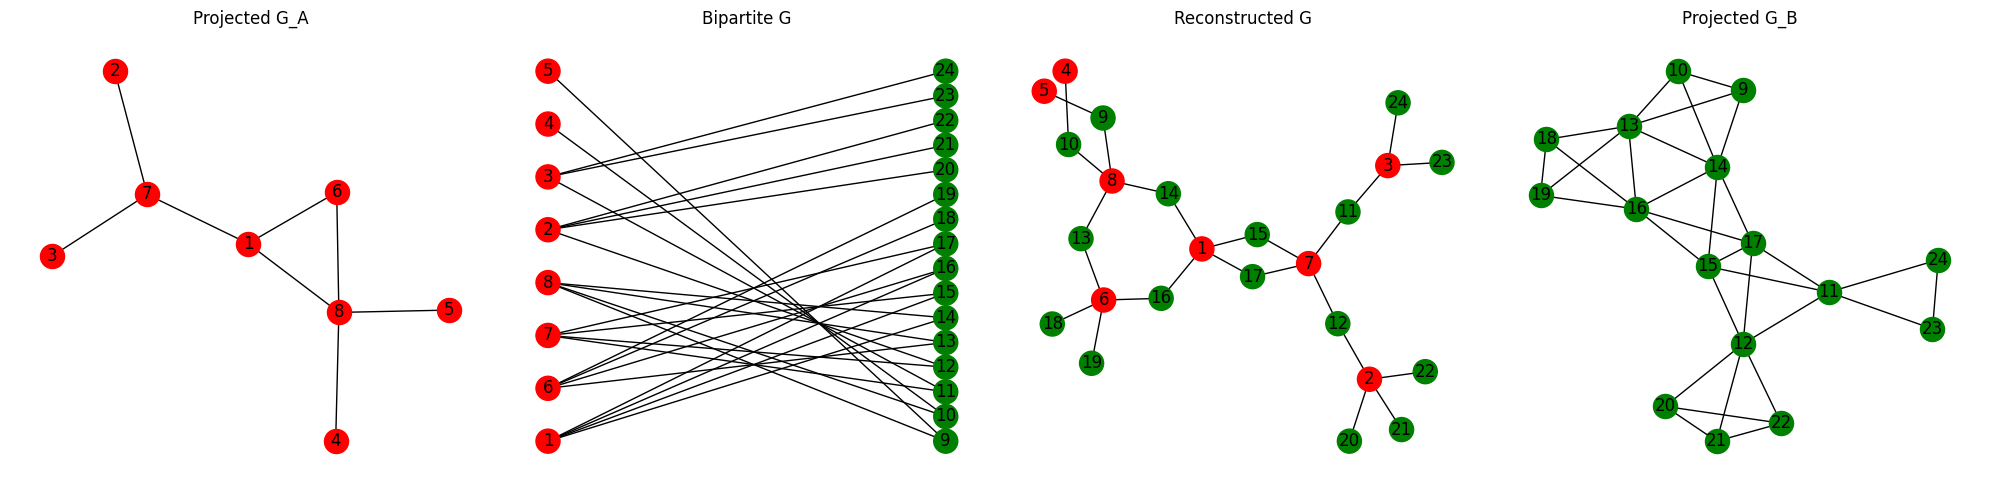

In [269]:
index = solution_indices[0]  # Choose a two-colorable topology
G_A_projected = two_colorable[index]  # Take one of the two-colorable graphs

G_rebuilt, G_A, G_B = construct_bipartite_graph(
    G_A_projected, num_B, max_degree_A=max_degree_A, max_degree_B=max_degree_B
)
if G_rebuilt:
    plot_graphs(G_rebuilt, G_A, G_B)

In [270]:
def topology_metric(G):
    if not nx.is_connected(G):
        raise ValueError("Graph must be connected to compute topology metrics.")

    # Average shortest path length
    avg_distance = nx.average_shortest_path_length(G)

    # Average connectivity: Mean of average degree connectivity values
    avg_connectivity = sum(nx.average_degree_connectivity(G).values()) / len(G.nodes())

    # Graph diameter: Max shortest path between any two nodes
    diameter = nx.diameter(G)

    return avg_distance, avg_connectivity, diameter


min_dist = float("inf")
for index in solution_indices:  # planar_indices:
    G_A_projected = two_colorable[index]  # Take one of the two-colorable graphs
    G_rebuilt, G_A, G_B = construct_bipartite_graph(
        G_A_projected, num_B, max_degree_A=max_degree_A, max_degree_B=max_degree_B
    )

    avg_dist, avg_conn, diam = topology_metric(G_B)
    # print(
    #     f"Index {index}: Avg Distance = {avg_dist:.2f}, Avg Connectivity = {avg_conn:.2f}, Diameter = {diam}"
    # )
    if avg_dist < min_dist:
        min_dist = avg_dist
        best_index = index
        print(
            f"Index {index}: Avg Distance = {avg_dist:.2f}, Avg Connectivity = {avg_conn:.2f}, Diameter = {diam}"
        )

print(f"Best index: {best_index}, Min Distance: {min_dist:.2f}")

Index 29: Avg Distance = 2.37, Avg Connectivity = 1.09, Diameter = 4
Index 30: Avg Distance = 2.17, Avg Connectivity = 0.88, Diameter = 4
Index 61: Avg Distance = 2.12, Avg Connectivity = 0.92, Diameter = 4
Index 62: Avg Distance = 1.98, Avg Connectivity = 1.17, Diameter = 4
Index 193: Avg Distance = 1.95, Avg Connectivity = 0.93, Diameter = 3
Index 247: Avg Distance = 1.91, Avg Connectivity = 1.25, Diameter = 3
Index 324: Avg Distance = 1.88, Avg Connectivity = 0.98, Diameter = 3
Index 724: Avg Distance = 1.86, Avg Connectivity = 1.60, Diameter = 4
Index 726: Avg Distance = 1.85, Avg Connectivity = 1.30, Diameter = 3
Index 1127: Avg Distance = 1.82, Avg Connectivity = 1.28, Diameter = 3
Index 1276: Avg Distance = 1.80, Avg Connectivity = 1.02, Diameter = 3
Index 1331: Avg Distance = 1.78, Avg Connectivity = 1.02, Diameter = 3
Index 1370: Avg Distance = 1.77, Avg Connectivity = 1.65, Diameter = 3
Index 1414: Avg Distance = 1.75, Avg Connectivity = 1.37, Diameter = 3
Index 1696: Avg Dis

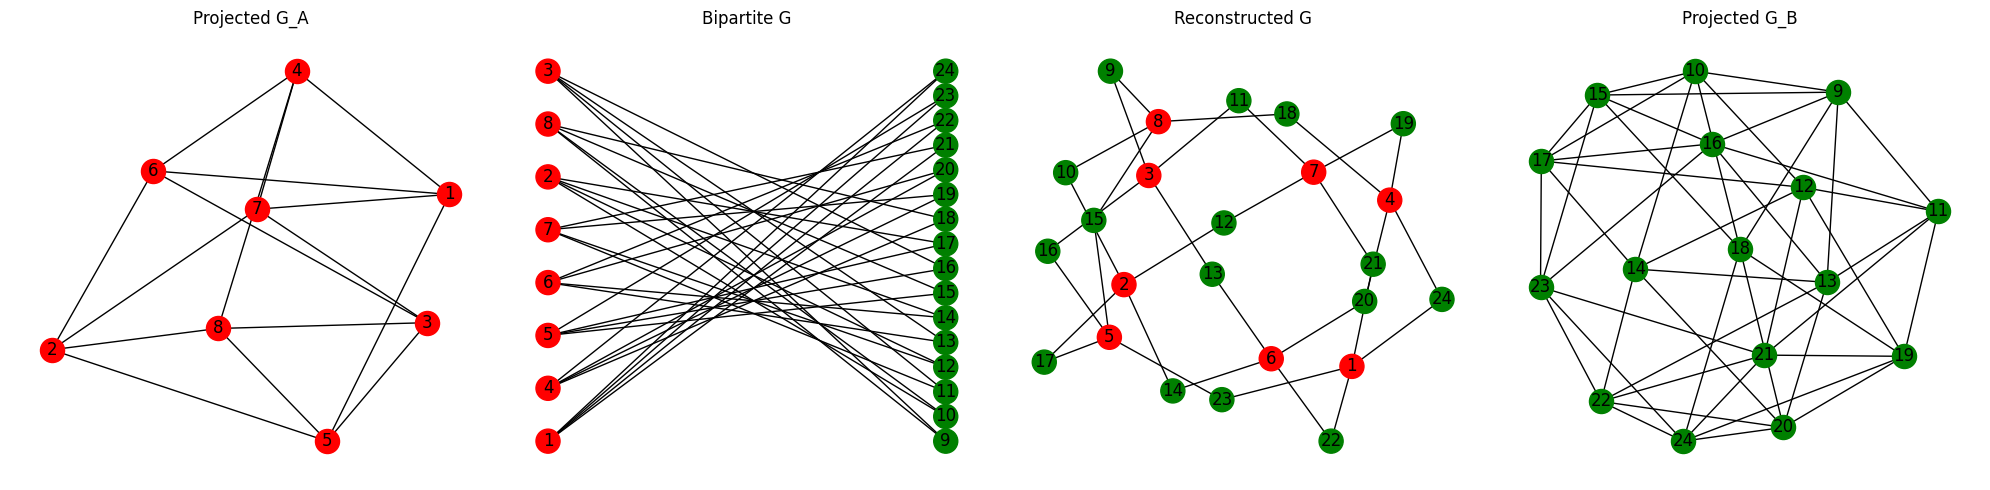

In [271]:
index = best_index  # Choose a two-colorable topology
G_A_projected = two_colorable[index]  # Take one of the two-colorable graphs

G_rebuilt, G_A, G_B = construct_bipartite_graph(
    G_A_projected, num_B, max_degree_A=max_degree_A, max_degree_B=max_degree_B
)
if G_rebuilt:
    plot_graphs(G_rebuilt, G_A, G_B)